In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split



cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
!pip install WandB
import wandb

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [ ]:
! kaggle datasets download jessicali9530/stanford-dogs-dataset

100% 749M/750M [00:08<00:00, 72.5MB/s]
100% 750M/750M [00:08<00:00, 92.5MB/s]


In [ ]:
! rm -rf annotations
! rm -rf images

In [ ]:
! unzip stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

In [ ]:
import copy
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Setting the directory for the dataset
data_dir = 'images/Images'
full_dataset = datasets.ImageFolder(data_dir)

# Determining the size of train and validation sets
test_size = int(0.1 * len(full_dataset))
data_size = len(full_dataset) - test_size
test_dataset, trimmed_dataset = random_split(full_dataset, [test_size, data_size])
test_dataset = copy.deepcopy(test_dataset)
trimmed_dataset = copy.deepcopy(trimmed_dataset)
print(len(trimmed_dataset))

train_size = int(0.8 * len(trimmed_dataset))
val_size = len(trimmed_dataset) - train_size

# Splitting the dataset
train_dataset, val_dataset = random_split(trimmed_dataset, [train_size, val_size])
train_dataset, val_dataset = copy.deepcopy(train_dataset), copy.deepcopy(val_dataset)
print(train_dataset.dataset.dataset.transform)

# Applying specific transforms to train and val datasets using Lambda
train_dataset.dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']
print(train_dataset.dataset.dataset.transform)

# Creating dataloaders for train and validation datasets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)
}

# Getting dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

class_names = full_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(dataloaders['train'].dataset.dataset.dataset.transform)

18522
None
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
cuda:0
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


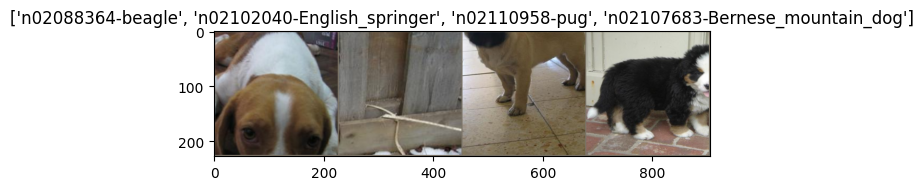

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [ ]:
import wandb

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Initialize WandB
    wandb.init(project="INF8225_Projet", name="training")

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_acc': epoch_acc})

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    wandb.finish()

    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

def evaluate(model_name, model, dataloader):
    was_training = model.training
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds += preds
            all_labels += labels

        model.train(mode=was_training)

    class_names = dataloader.dataset.dataset.classes

    # Map integer labels to class names
    label_map = {i: class_names[i] for i in range(len(class_names))}

    filtered_true_labels = [label for label in all_labels if 0 <= label <= 19]
    filtered_pred_labels = [all_preds[i] for i, label in enumerate(all_labels) if 0 <= label <= 19]
    print(filtered_true_labels)

    # Convert integer labels to class names
    true_labels = [label_map[label.item()] for label in filtered_true_labels]
    pred_labels = [label_map[label.item()] for label in filtered_pred_labels]
    print(true_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names[:20])

    # Plot confusion matrix
    plt.figure(figsize=(20, 16))
    sns.set(font_scale=1)  # Adjust font size for better readability
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the plot as an image file
    plt.savefig(f'confusion_matrix-{model_name}.png')

    # Download the saved file to your local machine
    files.download(f'confusion_matrix-{model_name}.png')

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [ ]:
def model_config(model_name, model):
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier[-1].in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
    model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

    evaluate(model_name, model, dataloaders['test'])


Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [ ]:
cnn_models = {'mobilenetV3': models.mobilenet_v3_small(weights='IMAGENET1K_V1')}
print(models.mobilenet_v3_small(weights='IMAGENET1K_V1').classifier[-1])

Linear(in_features=1024, out_features=1000, bias=True)


In [ ]:
!wandb online

!wandb login


W&B online. Running your script from this directory will now sync to the cloud.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: gabcoteprive (gabriel-cote). Use `wandb login --relogin` to force relogin


Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 3.9291 Acc: 0.1672
val Loss: 2.1475 Acc: 0.4850

Epoch 1/24
----------
train Loss: 3.1181 Acc: 0.2919
val Loss: 1.7127 Acc: 0.5479

Epoch 2/24
----------
train Loss: 2.8273 Acc: 0.3363
val Loss: 1.5309 Acc: 0.5749

Epoch 3/24
----------
train Loss: 2.7046 Acc: 0.3524
val Loss: 1.4207 Acc: 0.6030

Epoch 4/24
----------
train Loss: 2.5971 Acc: 0.3712
val Loss: 1.3694 Acc: 0.6081

Epoch 5/24
----------
train Loss: 2.5564 Acc: 0.3769
val Loss: 1.3196 Acc: 0.6224

Epoch 6/24
----------
train Loss: 2.4857 Acc: 0.3850
val Loss: 1.2858 Acc: 0.6329

Epoch 7/24
----------
train Loss: 2.4523 Acc: 0.3977
val Loss: 1.2960 Acc: 0.6294

Epoch 8/24
----------
train Loss: 2.4659 Acc: 0.3968
val Loss: 1.2721 Acc: 0.6354

Epoch 9/24
----------
train Loss: 2.4188 Acc: 0.4047
val Loss: 1.2851 Acc: 0.6340

Epoch 10/24
----------
train Loss: 2.4429 Acc: 0.4049
val Loss: 1.2864 Acc: 0.6318

Epoch 11/24
----------
train Loss: 2.4403 Acc: 0.4002
val Loss: 1.2759 Acc: 0.6337

Epoch 12/24
----------
t

train_acc,▁▅▆▆▇▇▇██████████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇███████▇██████▇███▇
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.40703
train_loss,2.40939
val_acc,0.62834
val_loss,1.30675


[tensor(13, device='cuda:0'), tensor(4, device='cuda:0'), tensor(9, device='cuda:0'), tensor(1, device='cuda:0'), tensor(8, device='cuda:0'), tensor(7, device='cuda:0'), tensor(0, device='cuda:0'), tensor(12, device='cuda:0'), tensor(17, device='cuda:0'), tensor(1, device='cuda:0'), tensor(15, device='cuda:0'), tensor(18, device='cuda:0'), tensor(7, device='cuda:0'), tensor(18, device='cuda:0'), tensor(17, device='cuda:0'), tensor(14, device='cuda:0'), tensor(5, device='cuda:0'), tensor(2, device='cuda:0'), tensor(10, device='cuda:0'), tensor(15, device='cuda:0'), tensor(4, device='cuda:0'), tensor(13, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(7, device='cuda:0'), tensor(11, device='cuda:0'), tensor(15, device='cuda:0'), tensor(9, device='cuda:0'), tensor(11, device='cuda:0'), tensor(5, device='cuda:0'), tensor(19, device='cuda:0'), tensor(4, device='cuda:0'), tensor(7, device='cuda:0'), tensor(4, device='cuda:0'), tensor(19, device='cuda:0'), ten

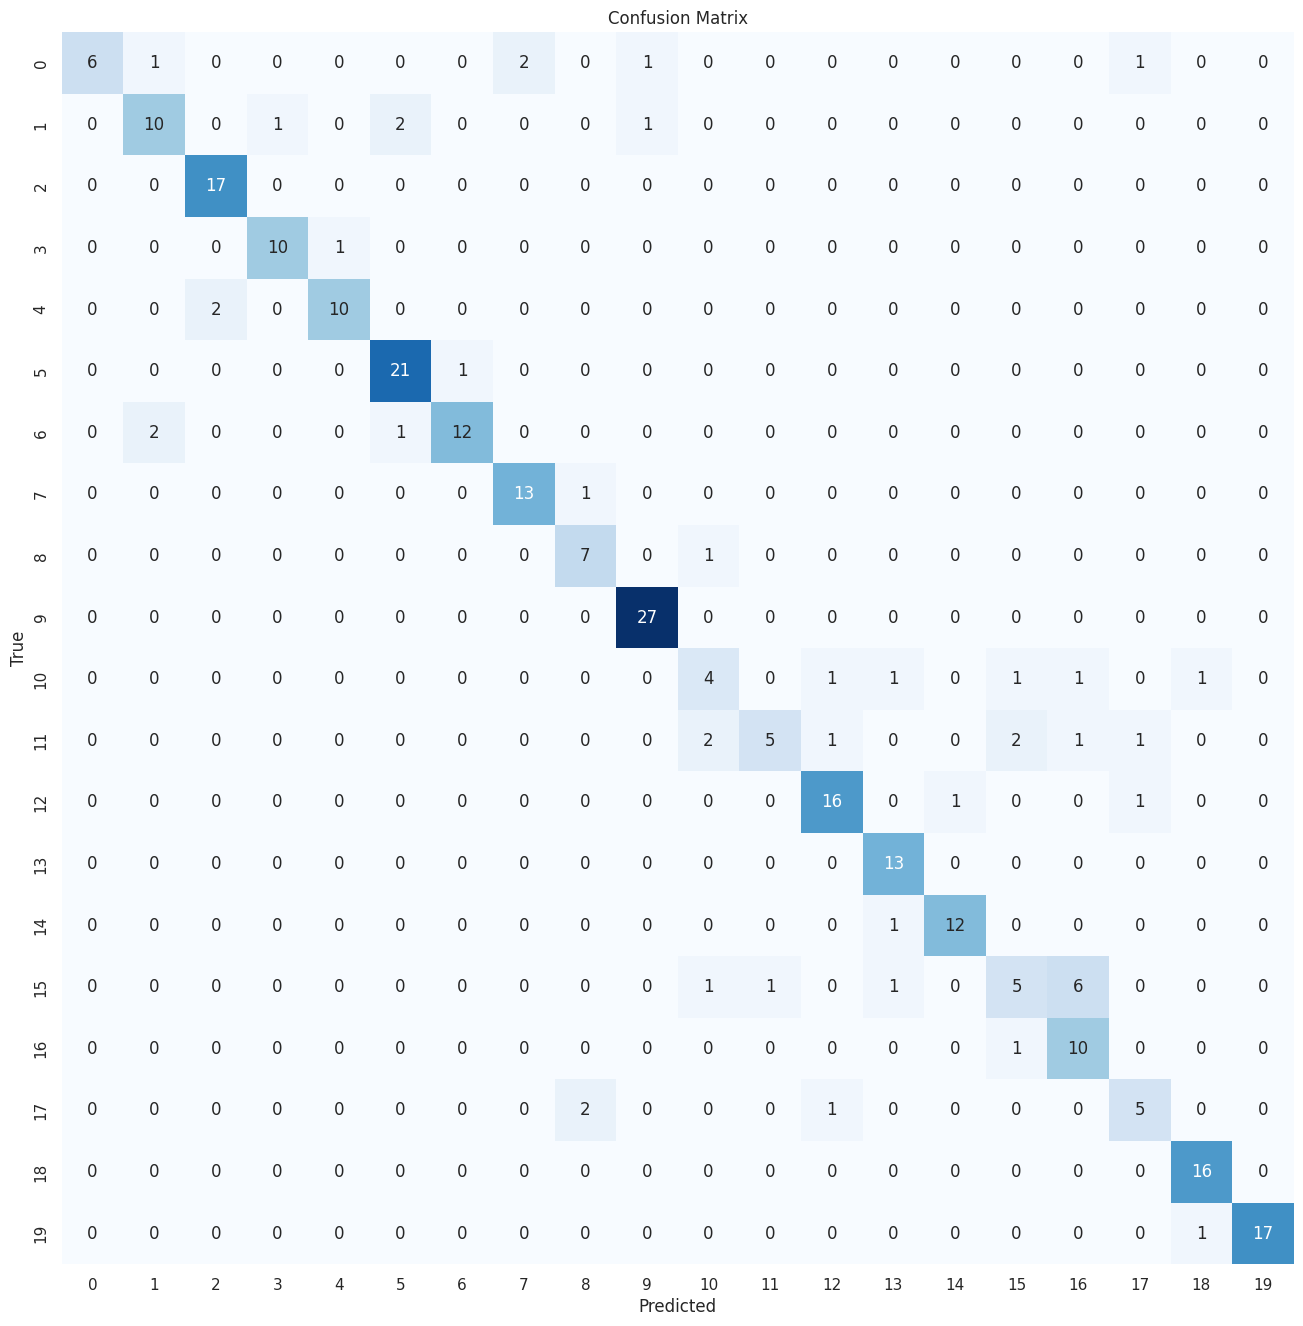

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
for model in cnn_models:
    model_config(model, cnn_models[model])

In [ ]:
evaluate('resnet18', model, dataloaders['test'])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.set(font_scale=1)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='images/Images/n02085620-Chihuahua/n02085620_10074.jpg'
)

plt.ioff()
plt.show()

Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
